In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']

In [3]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def assessme(y_true, y_pred, printme=False):
    met = {}
    met['mae'] = mean_absolute_error(y_true, y_pred)
    met['mse'] = mean_squared_error(y_true, y_pred)
    met['rmse'] = np.sqrt(met['mse'])
    met['r2'] = r2_score(y_true, y_pred)
    n, k = len(y_true), 1
    met['adj_r2'] = 1 - (1 - met['r2']) * (n - 1) / (n - k - 1)
    if printme:
        print(f" MAE: {met['mae']}\n MSE: {met['mse']}\n RMSE: {met['rmse']}\n R²: {met['r2']}\n Adjusted R²: {met['adj_r2']}")
    return met

### regressor

In [5]:
mm.run.max()

9

In [6]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [7]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [38]:
# beginning of generation
N = 10

# beginning of generation bears more information (AUC) than end of generation
ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

In [39]:
ds

,run,pid,maxp0,maxp1,maxp2,maxp3,maxp4,maxp5,maxp6,maxp7,maxp8,maxp9,true_ent0,true_ent1,true_ent2,true_ent3,true_ent4,true_ent5,true_ent6,true_ent7,true_ent8,true_ent9,correct,hallucinated
0,0,9,1.000000,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,0.999996,0.999969,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,6.502650e-05,4.334208e-04,False,False
1,0,10,1.000000,0.998764,0.999864,0.940220,1.000000,1.000000,0.999989,0.987074,0.999998,0.999959,1.616158e-06,0.012218,1.506806e-03,2.517824e-01,8.579906e-09,8.837126e-07,1.639340e-04,9.334140e-02,2.433762e-05,5.074464e-04,False,False
2,0,12,1.000000,0.997829,1.000000,0.999999,0.999999,0.996164,0.707576,1.000000,1.000000,0.999991,9.756351e-07,0.017998,5.711260e-07,1.362268e-05,1.221164e-05,2.904172e-02,6.464605e-01,2.070488e-08,1.401210e-06,1.227201e-04,False,False
3,0,14,1.000000,0.994415,0.999967,0.561076,1.000000,1.000000,0.768818,1.000000,1.000000,0.999991,2.472243e-06,0.035839,4.299130e-04,1.115004e+00,9.973774e-07,2.550019e-06,5.443041e-01,3.232657e-08,3.176602e-07,1.276724e-04,False,False
4,0,17,0.999999,0.842796,0.557818,1.000000,0.999991,0.999093,1.000000,1.000000,0.999991,0.999996,1.480168e-05,0.637194,6.945014e-01,2.445166e-06,1.360828e-04,8.025359e-03,8.336202e-09,5.174461e-07,1.205831e-04,5.824901e-05,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,9,1788,1.000000,0.999735,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.996888,0.999999,7.603943e-07,0.002725,9.010122e-06,1.137201e-05,3.049808e-06,2.346361e-07,1.727000e-08,1.542884e-06,2.139582e-02,1.466352e-05,True,False
6876,9,1789,1.000000,0.998938,1.000000,1.000000,0.999998,0.966994,1.000000,1.000000,0.999837,0.975813,7.446607e-07,0.008928,6.993531e-08,1.876450e-06,2.689730e-05,1.488801e-01,1.133345e-08,9.309534e-07,1.654437e-03,1.154494e-01,True,False
6877,9,1790,1.000000,0.999904,0.999928,1.000000,0.996329,1.000000,0.999998,1.000000,1.000000,1.000000,5.459514e-06,0.001212,7.720306e-04,1.245706e-06,2.812353e-02,3.760191e-06,3.647040e-05,8.510714e-06,1.821284e-07,9.020661e-09,False,False
6878,9,1794,1.000000,0.984611,1.000000,1.000000,0.999913,0.983362,1.000000,1.000000,0.999995,1.000000,6.141302e-06,0.091519,2.436548e-07,4.925757e-07,9.596071e-04,1.008549e-01,7.226087e-08,3.133798e-06,7.783296e-05,2.372521e-06,True,False


In [40]:
ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')

In [41]:
ds.correct.value_counts()

correct
True     4779
False    1881
Name: count, dtype: int64

In [42]:
# WARNING here we are dropping duplicates (include correct as variable)
ds = ds.drop_duplicates(ds.columns[1:-3])

In [43]:
ds

,run,pid,maxp0,maxp1,maxp2,maxp3,maxp4,maxp5,maxp6,maxp7,maxp8,maxp9,true_ent0,true_ent1,true_ent2,true_ent3,true_ent4,true_ent5,true_ent6,true_ent7,true_ent8,true_ent9,correct,hallucinated,answers_entropy_norm,correct_mean
0,0,9,1.0,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,0.999996,0.999969,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,6.502650e-05,4.334208e-04,False,False,0.547371,0.666667
1,1,9,1.0,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,1.000000,0.999998,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,1.963413e-06,2.542405e-05,False,False,0.547371,0.666667
3,3,9,1.0,0.992606,1.000000,0.518202,0.999998,1.000000,1.000000,0.999337,0.996735,1.000000,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,3.900399e-05,3.894976e-08,1.299983e-06,5.816230e-03,2.363233e-02,9.276389e-07,True,False,0.547371,0.666667
7,7,9,1.0,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,1.000000,1.000000,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,1.103188e-05,2.230653e-06,False,False,0.547371,0.666667
10,0,10,1.0,0.998764,0.999864,0.940220,1.000000,1.000000,0.999989,0.987074,0.999998,0.999959,1.616158e-06,0.012218,1.506806e-03,2.517824e-01,8.579906e-09,8.837126e-07,1.639340e-04,9.334140e-02,2.433762e-05,5.074464e-04,False,False,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6620,0,1789,1.0,0.998938,1.000000,1.000000,0.999998,0.966994,1.000000,1.000000,0.999837,0.975813,7.446607e-07,0.008928,6.993531e-08,1.876450e-06,2.689730e-05,1.488801e-01,1.133345e-08,9.309534e-07,1.654437e-03,1.154494e-01,True,False,0.000000,1.000000
6630,0,1790,1.0,0.999904,0.999928,1.000000,0.996329,1.000000,0.999998,1.000000,1.000000,1.000000,5.459514e-06,0.001212,7.720306e-04,1.245706e-06,2.812353e-02,3.760191e-06,3.647040e-05,8.510714e-06,1.821284e-07,9.020661e-09,False,False,0.000000,0.000000
6640,0,1794,1.0,0.984611,1.000000,1.000000,0.999913,0.983362,1.000000,1.000000,0.999995,1.000000,6.141302e-06,0.091519,2.436548e-07,4.925757e-07,9.596071e-04,1.008549e-01,7.226087e-08,3.133798e-06,7.783296e-05,2.372521e-06,True,False,0.000000,1.000000
6650,0,1797,1.0,0.999925,0.999996,1.000000,1.000000,1.000000,1.000000,0.827240,0.999999,1.000000,3.463509e-07,0.000818,5.827549e-05,3.070424e-07,1.018147e-07,2.408649e-09,1.065855e-06,5.202428e-01,1.655960e-05,1.533124e-07,True,False,0.000000,1.000000


In [44]:
y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

In [45]:
X.loc[:,X.nunique()!=1].shape

(1043, 20)

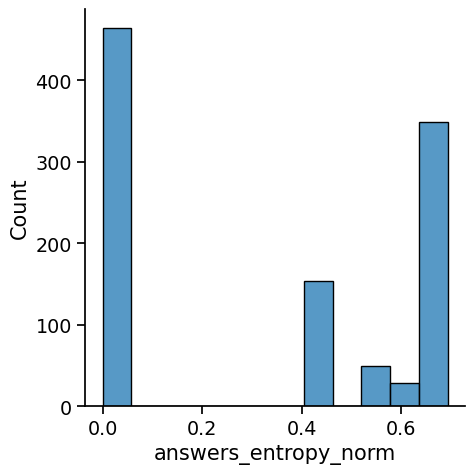

In [46]:
sns.displot(y)

In [47]:
X.isnull().sum().sum() == 0

True

In [48]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [49]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation, entropy

In [50]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 4.46 s, sys: 240 ms, total: 4.7 s
Wall time: 624 ms


In [51]:
#def jitter(values,j):
#    return values + np.random.normal(j,0.01,values.shape)
#ax = sns.scatterplot(y=jitter(pred,0.01), x=jitter(y_res.values, 0.01), hue=correct_mean, size=4)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
#plt.show()

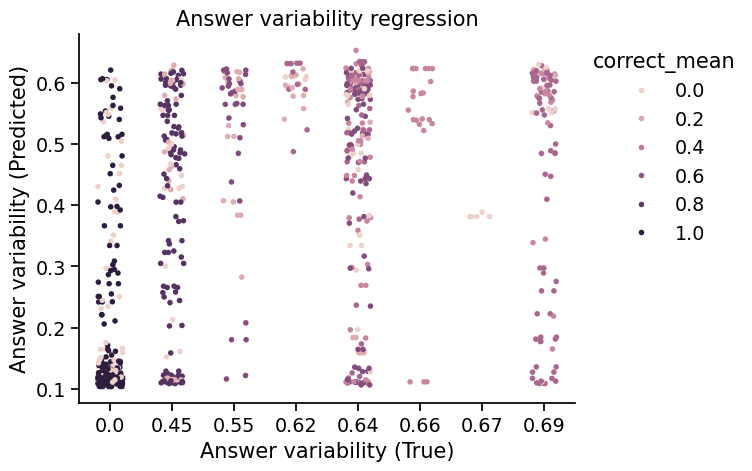

In [52]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [53]:
set(np.round(y_res.values,2).astype(str))

{'0.0', '0.45', '0.55', '0.62', '0.64', '0.66', '0.67', '0.69'}

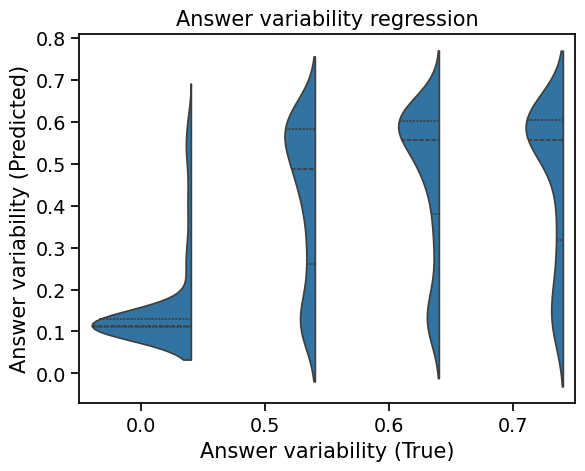

In [54]:
ax = sns.violinplot(y=pred, x=np.round(y_res.values,1), 
                    split=True, inner="quart", width=0.8) # , log_scale=(True,False))


plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [55]:
met = assessme(y_res.values, pred)

 MAE: 0.16768824183702596
 MSE: 0.04937129880185559
 RMSE: 0.22219653193030622
 R²: 0.4558247911408877
 Adjusted R²: 0.4553020483850192


In [56]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

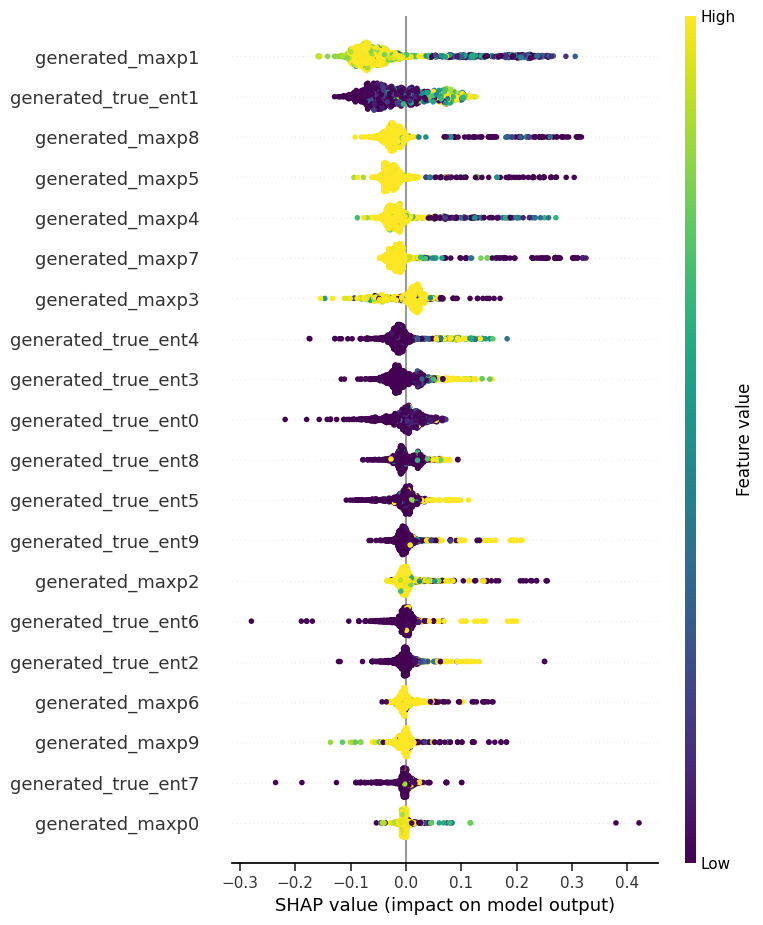

In [57]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [58]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [59]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.585325
generated_true_ent    0.414675
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

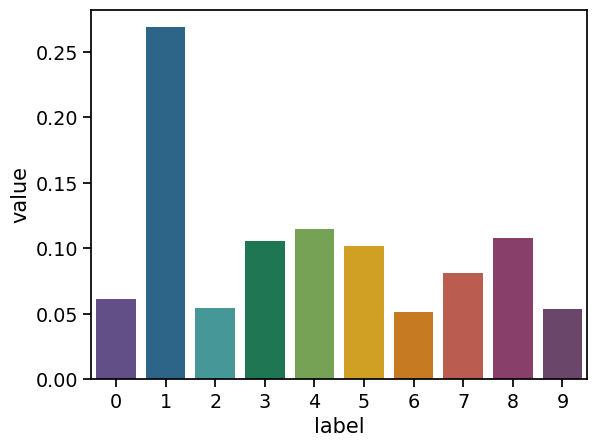

In [60]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

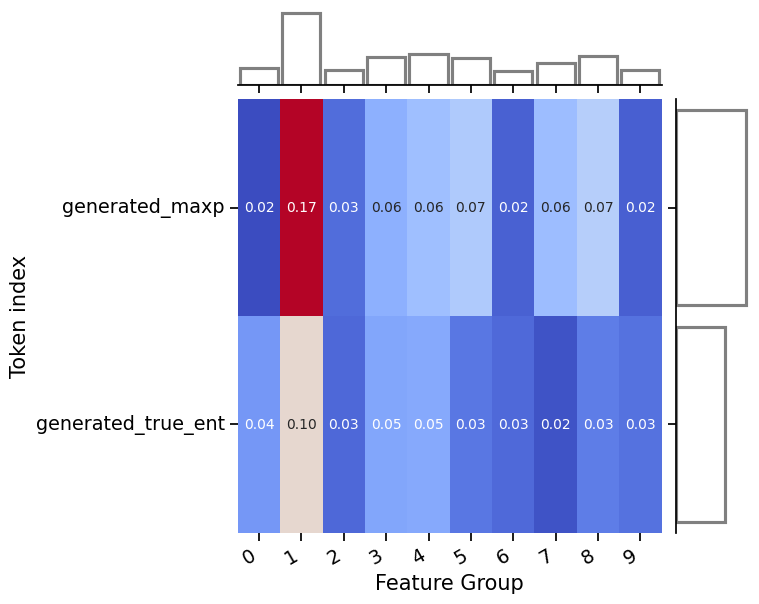

In [61]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### increasing number of cases

In [155]:
ds.pid.nunique()

666

In [171]:
# test randomness
ds = ds.sample(frac=1)

In [172]:
y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

In [173]:
group_kfold = GroupKFold(n_splits=10)

foldlist = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, pids)):
    foldlist.append(test_index)

In [174]:
%%time

prog = []

# cycle all
for i, idxs in enumerate(foldlist):
    print(i)
    
    test_idx = idxs
    
    # cycle all, skipping i
    train_idx = set()
    c = 0
      
    foldlist_ = [idxs_ for j, idxs_ in enumerate(foldlist) if i != j]
    fold_train_idx = np.concatenate(foldlist_)
    
    # cycle all available pids
    fold_pids = pids.iloc[fold_train_idx]
    
    for pid in tqdm(fold_pids.unique()):
        
        # enlarge dataset one pid at a time
        train_idx = set(train_idx) | set(fold_train_idx[fold_pids == pid]) 
        train_idx = list(train_idx)

        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)
        xgb_model.fit(X.iloc[train_idx], y.iloc[train_idx])

        pred = xgb_model.predict(X.iloc[test_idx])
        
        # always test on out-of-fold data
        met = assessme(y.iloc[test_idx].values, pred)

        prog.append((i, j, c, len(train_idx), met['mae'], met['mse'], met['rmse'], met['r2']))
        c += 1
            

0


100%|█████████████████████████████████████████| 599/599 [00:31<00:00, 19.15it/s]


1


100%|█████████████████████████████████████████| 599/599 [00:32<00:00, 18.35it/s]


2


100%|█████████████████████████████████████████| 599/599 [00:28<00:00, 20.72it/s]


3


100%|█████████████████████████████████████████| 600/600 [00:30<00:00, 19.82it/s]


4


100%|█████████████████████████████████████████| 600/600 [00:31<00:00, 19.30it/s]


5


100%|█████████████████████████████████████████| 600/600 [00:32<00:00, 18.60it/s]


6


100%|█████████████████████████████████████████| 600/600 [00:30<00:00, 19.73it/s]


7


100%|█████████████████████████████████████████| 599/599 [00:29<00:00, 20.59it/s]


8


100%|█████████████████████████████████████████| 599/599 [00:32<00:00, 18.40it/s]


9


100%|█████████████████████████████████████████| 599/599 [00:32<00:00, 18.44it/s]

CPU times: user 37min 2s, sys: 3min 4s, total: 40min 7s
Wall time: 5min 10s


In [175]:
prog_ = pd.DataFrame(prog, columns=['i', 'j', 'c', 'n', 'mae', 'mse', 'rmse', 'r2'])

In [176]:
prog_.shape

(5994, 8)

In [177]:
prog_

,i,j,c,n,mae,mse,rmse,r2
0,0,8,0,2,0.367331,0.232573,0.482258,-1.381917
1,0,8,1,9,0.367331,0.232573,0.482258,-1.381917
2,0,8,2,11,0.348626,0.211643,0.460047,-1.167567
3,0,8,3,13,0.349133,0.208758,0.456900,-1.138016
4,0,8,4,14,0.249305,0.104508,0.323277,-0.070328
...,...,...,...,...,...,...,...,...
5989,9,8,594,935,0.138876,0.033631,0.183388,0.625108
5990,9,8,595,936,0.141875,0.034325,0.185269,0.617378
5991,9,8,596,937,0.141951,0.034935,0.186910,0.610569
5992,9,8,597,938,0.141952,0.035025,0.187151,0.609566


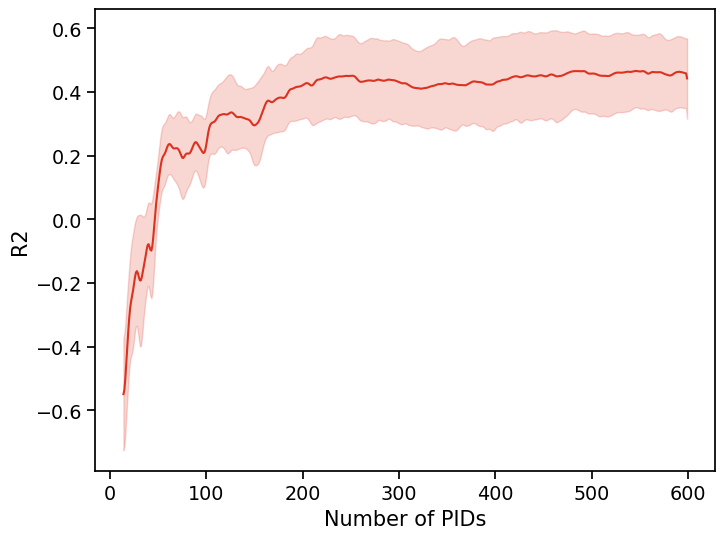

In [187]:
def smooth_data(df, column, window=10):
    return df.groupby("i")[column].transform(lambda x: x.rolling(window, win_type="gaussian").mean(std=2))

prog_["mae_smooth"] = smooth_data(prog_, "mae", window=15)
prog_["r2_smooth"] = smooth_data(prog_, "r2", window=15)

plt.figure(figsize=(8, 6))
sns.lineplot(prog_, x="c", y="r2_smooth", errorbar="sd", color='#DC3220')
# plt.title("Entropy regression MAE over number of PIDs in training")
plt.xlabel("Number of PIDs")
plt.ylabel("R2")
plt.show()

<Axes: xlabel='c', ylabel='mae'>

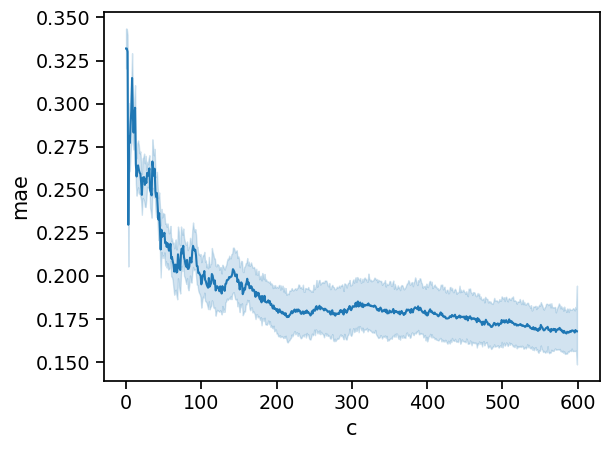

In [178]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

<Axes: xlabel='c', ylabel='mae'>

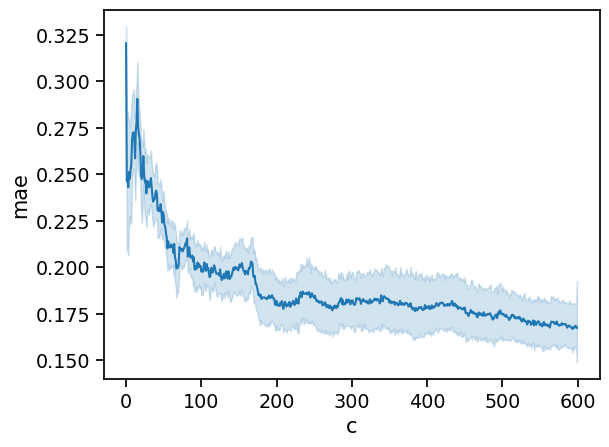

In [166]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

### beginning of generation, accuracy

In [37]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, correct_mean, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 5.98 s, sys: 3.47 s, total: 9.45 s
Wall time: 1.24 s


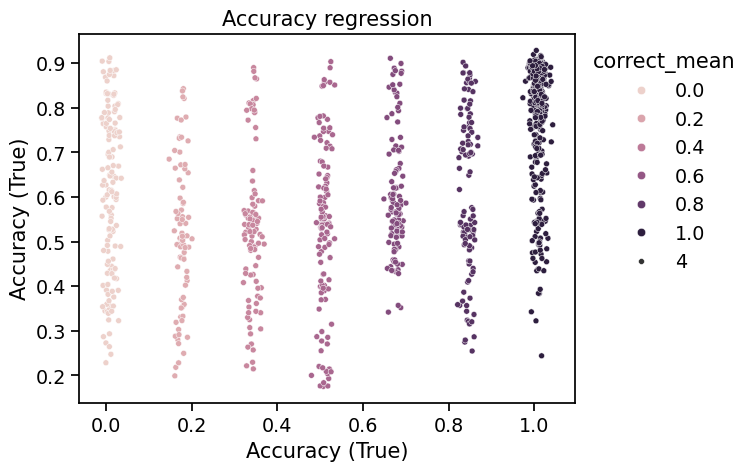

In [48]:
import matplotlib.pyplot as plt

def jitter(values,j):
    return values + np.random.normal(j,0.01,values.shape)

ax = sns.scatterplot(y=jitter(pred,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, size=4)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [39]:
met = assessme(correct_mean.values, pred)

 MAE: 0.26447639130258305
 MSE: 0.10927879250254531
 RMSE: 0.3305734298193751
 R²: 0.1880829118677323
 Adjusted R²: 0.18730297230180315


In [40]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, correct_mean)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [41]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [43]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.432009
generated_true_ent    0.567991
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

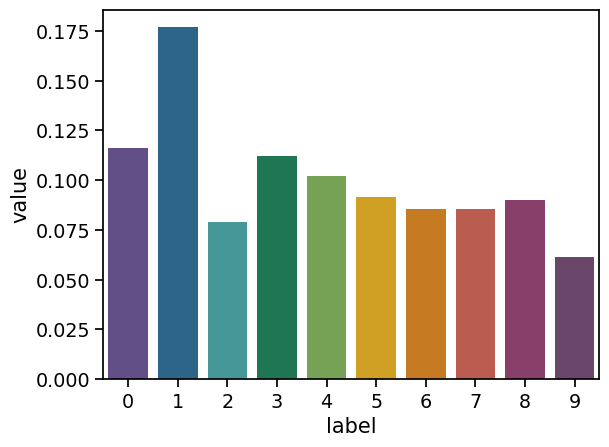

In [42]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

### postilla

In [138]:
# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates (include correct as variable)
ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla = y_res
X_res.columns = ['postilla_'+col for col in X.columns]

In [140]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 30.8 s, sys: 1.3 s, total: 32.1 s
Wall time: 4.83 s


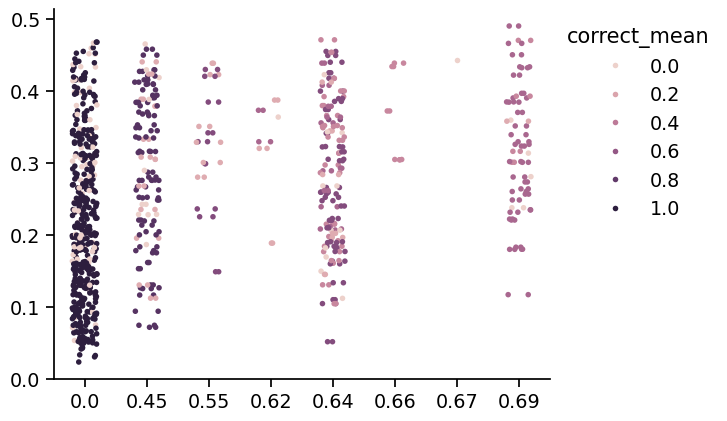

In [141]:
ax = sns.stripplot(y=pred_postilla, x=np.round(y_res_postilla.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()